# Finding Temporal Dependence on Databases
Joaquin Cuomo

## Functions

In [1]:
!pip install pymannkendall
!pip install gdown
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import os
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.tsa.arima_process as arima
import matplotlib.pyplot as plt
import numpy as np
import pymannkendall as mk
import zipfile
import numbers
from statsmodels.tsa.stattools import acf, pacf
import copy
import statsmodels as sm 
from IPython.display import clear_output
import pickle
from IPython.display import display, HTML

clear_output()

In [2]:
def analyze(serie, lags=20, plot=True, verbose=False):
    '''
    Analysis a 1D series for autocorrelation.
    INPUT
    serie: numerical array to be analyzed
    lags: number of temporal lags up to where to test for autocorrelation
    plot: TRUE if you want to plot results
    OUTPUT
    test: TRUE if autocorrleation is both statistically and quantitative significant
    result: acumulation of all significant autocorrelations at different lags
    '''
    if len(serie)<lags: #if lags is larger than the length of the series it changes the value 
        lags = int(np.floor(len(serie)/2))
        
    _, p = acorr_ljungbox(serie, lags=lags) # ljung-box test, where p is the statitical significance for each lag
    
    acf_x, confint = acf(serie, nlags=lags, alpha=0.05, fft=False, unbiased=False) #autocorrelation function
    q_thrhld = 0.5    # quantitative threshold for considering an autocorrelation value in the analysis (not the same as statistically significant)
    s_thrhld = 0.05 # statistically significant threshold 
    # filters those acorr values not significants (both statistical and quantitative)
    signif = ((acf_x > (confint[:,1]-acf_x)) | (acf_x < (confint[:,0]-acf_x))) & ((acf_x > q_thrhld) | (acf_x < -q_thrhld))
    signif[0] = False # remove lag 0
    result = sum([np.abs(x) for x, y in zip(acf_x, signif) if y == True]) # acum of all autocorr

    if plot:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4,figsize=(35,3))
        ax1.plot(serie) # plot series in time
        plot_acf(serie, lags=lags, ax=ax2); # plot autocorrelation
        plot_pacf(serie, lags=lags, ax=ax3); # plot partial autocorrelation
        ax4.stem(p, basefmt=" ", use_line_collection=True) # plot ljung-box test significance values
        ax4.plot([0,lags],[s_thrhld,s_thrhld],'r') # plot ljung-box test significance threshold
        print(mk.original_test(serie))
    test = any(p<s_thrhld) and any(signif) # True if there is any significant acorr
    return test, result 

def analyzeDB(df):
    '''
    Analysis a 2D database for autocorrelation in every column.
    INPUT
    df: panda dataframe
    OUTPUT
    cols: attributes with autocorrelation
    acum_corr: list of autocorrelation for each attribute
    '''
    columns = list(df) # name of each attribute
    test=[]
    acum_corr = []

    for i in columns: # for each attribute
        if np.issubdtype(df[i].dtype, np.number): # if it is numerical
            itest , iacum_corr = analyze(df[i], plot=False) # analyze it for acorr
            test = np.append(test, itest) # append the boolean result
            acum_corr = np.append(acum_corr, iacum_corr) # append the acorr value
        else: # if not just add as it does not have acorr
            test = np.append(test, 0)
            acum_corr = np.append(acum_corr, 0)

    cols = [x for x, y in zip(columns, test) if y == 1] # keep attributes with acorr
    acum_corr = [x for x, y in zip(acum_corr, test) if y == 1] # keep values with acorr
    if not acum_corr: #if none attribute had acorr create one with 0
        acum_corr = [0]
    return cols, acum_corr

def analyzeDB_attGrouping(df, verbose=False):
    '''
    Analysis a 2D database for autocorrelation in every column by grouping each column by same-value rows
    INPUT
    df: panda dataframe
    OUTPUT
    summary_df: panda datafram with [rows: list of attributes], [columns: metrics to evaluate temporal dependence]
        metrics=['% data','groups', 'avg_temp_att', 'std', 'avg_corr', 'max_corr'] (see paper for explanation)
    results: dictionary with [key:attributes][key:value in that attribute]=[list of attributes with acorr, list of attributes' acorrs]
    '''
    results = dict()

    for col in list(df): # for each column
        results[col] = dict() # create an entry in a dictionary
        for att in df[col].unique(): # for each unique value
            try:
                corr_att, corrs = analyzeDB(df.loc[df[col] == att]) # filter the df by that value and look for columns with acorr
                if corr_att and corrs: # if any was found
                    results[col][att] = [corr_att, corrs] # add it to the dictionary
                    if verbose:
                        print("Attribute, value, length:",col, att, len(df.loc[df[col] == att]))
                        print(corr_att)
                        print(corrs)
            except:
                pass
    summary = copy.deepcopy(results) 
    
    for key, value in results.items(): # for each column and column values
        list_n_corr_att = []
        list_max_corr = [0]
        acum_grouping = 0
        for key2, value2 in value.items(): # for each column values and the columns with acorr
            _, c = value2
            list_n_corr_att = np.append(list_n_corr_att, len(c)) # append the count of columns with acorr
            list_max_corr = np.append(list_max_corr, np.max(c))    # append the max acorr
            acum_grouping += len(df.loc[df[key] == key2]) # acumulate the rows used
        # add to the dictionary for every column: % data used, groups, avg_temp_att, std, avg_corr, max_corr
        summary[key] = [int(100*acum_grouping/len(df)), len(list_n_corr_att), np.mean(list_n_corr_att), np.std(list_n_corr_att), np.mean(list_max_corr), np.max(list_max_corr)]

    t, c = analyzeDB(df) 
    results['no-grouping'] = dict()
    results['no-grouping']['n/a'] = [t, c]    

    # analyze the df without grouping
    t, c = analyzeDB(df) 
    #add the results to the dict
    summary['no-grouping'] = [100,1, len(t), 0, np.mean(c), np.max(c)]
    #create a dataframe
    summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['% data','groups', 'avg_temp_att', 'std', 'avg_corr', 'max_corr'])
    summary_df_aux = summary_df.copy(deep = True)
    decided_group_att = False
    while decided_group_att==False:
        grouping_att = summary_df_aux[['avg_temp_att']].idxmax().item()
        if summary_df_aux['% data'][grouping_att] < 50:
            summary_df_aux = summary_df_aux.drop(grouping_att)
        elif summary_df_aux['groups'][grouping_att] ==1 and grouping_att is not 'no-grouping':
            summary_df_aux = summary_df_aux.drop(grouping_att)
        else:
            decided_group_att = True
        
    print("Most probable grouping attribute is:",grouping_att)
    return summary_df, results,grouping_att

def getTemporalAtt(df, result, summary, filter_att=None):
    '''
    Extract attributes with autocorrelation using analyzeDB_attGrouping() output
    INPUT
    df: panda dataframe
    result: second output from analyzeDB_attGrouping()
    summary: first output from analyzeDB_attGrouping()
    filter_att: if not specify it will use the one with higher average of temporal sequences detected
    OUTPUT
    output: panda datafram with [rows: list of attributes with autocorrelation when grouping by filter_att], 
                                                            [columns: % of unique values (in filter_att) that detected autocorrelation for that row-attribute]
    '''
    if filter_att==None: # if no filter attibute is given
        filter_att = summary[['avg_temp_att']].idxmax().item() # use the one with the highest average of temporal sequences detected
    print("Filter attibute", filter_att)
    groups = summary['groups'][filter_att] # get in how many groups autocorrelated attributes where found
    dicAttCount = dict()
    for key,value in result[filter_att].items(): # for each column value and list of attributes with acorr
        for a in value[0]: # for each attributes with acorr 
            if a not in dicAttCount: # if the attribute is not already in the dict
                dicAttCount[a] = 1 # initialize it with 0
            else:
                dicAttCount[a] +=1 # else increment the count
    for k in dicAttCount.keys(): # for each count
        dicAttCount[k] /= groups/100 # calculate the percentage
    #create the output dataframe
    output = pd.DataFrame.from_dict(dicAttCount, orient='index',columns=['Ocurrences [%]'])
    thr = 50 #np.mean(output['Ocurrences [%]'])-np.std(output['Ocurrences [%]']) #calculate a naive threshold
    print('Threshold =', thr)
    return output

def shuffle_validation(df, groupAtt, tempAtt):
        sdf = df.sample(frac = 1)
        for group_value in df[groupAtt].unique():
                aux_df = df.loc[df[groupAtt] == group_value]
                cols, _ = analyzeDB(aux_df)

## Set up Databases

In [3]:
#download some databases
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
!wget https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv
clear_output()

In [3]:
# set up kaggle to download their datasets
#you need to upload a kaggle.json file that can be get from the kaggle Account->API
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

## Anlayze Databases

In [4]:
results = dict()

### COVID:daily number of cases and deaths nationwide

In [6]:
df = pd.read_csv('us.csv')
df

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0
...,...,...,...
374,2021-01-29,25971349,436780
375,2021-01-30,26105263,439421
376,2021-01-31,26218775,441285
377,2021-02-01,26358607,443235


In [7]:
s,r,g = analyzeDB_attGrouping(df)
s

Most probable grouping attribute is: no-grouping


,% data,groups,avg_temp_att,std,avg_corr,max_corr
date,0,0,NaN,NaN,0.000000,0.000000
cases,0,0,NaN,NaN,0.000000,0.000000
deaths,10,1,1.0,0.0,0.791398,1.582797
no-grouping,100,1,2.0,0.0,17.774385,17.930101


In [8]:
dfa = getTemporalAtt(df, r, s)
dfa

Filter attibute no-grouping
Threshold = 50


,Ocurrences [%]
cases,100.0
deaths,100.0


In [9]:
results['covid1'] = dict()
results['covid1']['att'] = list(df.columns)
results['covid1']['att_n'] = [x for x in df.columns  if np.issubdtype(df[x].dtype, np.number)]
results['covid1']['att_t'] = ['cases', 'deaths']
results['covid1']['summary'] = s
results['covid1']['g_att'] = g
results['covid1']['gd'] = False
results['covid1']['att_td'] = [idx for idx,row in dfa.iterrows() if row['Ocurrences [%]']>50]
results['covid1']

{'att': ['date', 'cases', 'deaths'],
 'att_n': ['cases', 'deaths'],
 'att_t': ['cases', 'deaths'],
 'summary':              % data  groups  avg_temp_att  std   avg_corr   max_corr
 date              0       0           NaN  NaN   0.000000   0.000000
 cases             0       0           NaN  NaN   0.000000   0.000000
 deaths           10       1           1.0  0.0   0.791398   1.582797
 no-grouping     100       1           2.0  0.0  17.774385  17.930101,
 'g_att': 'no-grouping',
 'gd': False,
 'att_td': ['cases', 'deaths']}

### COVID: daily number of cases and deaths county-wise



In [10]:
!wget https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv

--2021-04-01 08:04:00--  https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48199156 (46M) [text/plain]
Saving to: ‘us-counties.csv.7’

us-counties.csv.7   100%[===================>]  45.97M  1.62MB/s    in 26s     

2021-04-01 08:04:28 (1.74 MB/s) - ‘us-counties.csv.7’ saved [48199156/48199156]



In [11]:
df = pd.read_csv('us-counties.csv')
df

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0
...,...,...,...,...,...,...
991912,2021-02-02,Sweetwater,Wyoming,56037.0,3510,33.0
991913,2021-02-02,Teton,Wyoming,56039.0,3151,7.0
991914,2021-02-02,Uinta,Wyoming,56041.0,1975,12.0
991915,2021-02-02,Washakie,Wyoming,56043.0,867,26.0


In [12]:
df.loc[df['county'] == 'Boulder'].tail(10)

,date,county,state,fips,cases,deaths
959712,2021-01-24,Boulder,Colorado,8013.0,16848,219.0
962957,2021-01-25,Boulder,Colorado,8013.0,16894,225.0
966202,2021-01-26,Boulder,Colorado,8013.0,16956,229.0
969446,2021-01-27,Boulder,Colorado,8013.0,17100,230.0
972691,2021-01-28,Boulder,Colorado,8013.0,17148,231.0
975936,2021-01-29,Boulder,Colorado,8013.0,17225,232.0
979181,2021-01-30,Boulder,Colorado,8013.0,17279,232.0
982427,2021-01-31,Boulder,Colorado,8013.0,17329,232.0
985674,2021-02-01,Boulder,Colorado,8013.0,17376,232.0
988921,2021-02-02,Boulder,Colorado,8013.0,17433,232.0


In [13]:
s,r,g = analyzeDB_attGrouping(df)
s

Most probable grouping attribute is: county


,% data,groups,avg_temp_att,std,avg_corr,max_corr
date,0,18,1.000000,0.000000,0.820709,1.681197
county,99,1927,2.159315,0.506363,16.542085,19.672386
state,9,19,1.842105,0.364642,4.278340,18.517124
fips,99,3216,1.952736,0.212202,17.516142,18.813475
cases,0,361,1.022161,0.147206,0.634591,1.703790
deaths,1,345,1.066667,0.249444,0.817670,3.475165
no-grouping,100,1,0.000000,0.000000,0.000000,0.000000


In [14]:
dfa = getTemporalAtt(df, r, s)
dfa

Filter attibute county
Threshold = 50


,Ocurrences [%]
cases,99.792423
deaths,93.720810
fips,22.418267


In [15]:
results['covid2'] = dict()
results['covid2']['att'] = list(df.columns)
results['covid2']['att_n'] = [x for x in df.columns  if np.issubdtype(df[x].dtype, np.number)]
results['covid2']['att_t'] = ['cases', 'deaths']
results['covid2']['summary'] = s
results['covid2']['g_att'] = g
results['covid2']['gd'] = True
results['covid2']['att_td'] = [idx for idx,row in dfa.iterrows() if row['Ocurrences [%]']>50]
results['covid2']

{'att': ['date', 'county', 'state', 'fips', 'cases', 'deaths'],
 'att_n': ['fips', 'cases', 'deaths'],
 'att_t': ['cases', 'deaths'],
 'summary':              % data  groups  avg_temp_att       std   avg_corr   max_corr
 date              0      18      1.000000  0.000000   0.820709   1.681197
 county           99    1927      2.159315  0.506363  16.542085  19.672386
 state             9      19      1.842105  0.364642   4.278340  18.517124
 fips             99    3216      1.952736  0.212202  17.516142  18.813475
 cases             0     361      1.022161  0.147206   0.634591   1.703790
 deaths            1     345      1.066667  0.249444   0.817670   3.475165
 no-grouping     100       1      0.000000  0.000000   0.000000   0.000000,
 'g_att': 'county',
 'gd': True,
 'att_td': ['cases', 'deaths']}

### Energy database

In [16]:
#!gdown https://drive.google.com/uc?id=19nX4mQKftp_8QyP7m3mdcdhuPBci66iy
df = pd.read_csv('pow_temp_isweekday.csv')
df = df.dropna()
df

,id,time,Temp,dailyDelivered,isWeekend
0,1,2019-01-01 00:00:00-07:00,7.133333,2.011245e+06,0
1,2,2019-01-02 00:00:00-07:00,18.237500,1.835738e+06,0
2,3,2019-01-03 00:00:00-07:00,30.658333,1.615089e+06,0
3,4,2019-01-04 00:00:00-07:00,36.708333,1.481572e+06,0
4,5,2019-01-05 00:00:00-07:00,39.608333,1.478756e+06,1
...,...,...,...,...,...
542,543,2020-06-26 00:00:00-07:00,67.225000,1.418004e+06,0
543,544,2020-06-27 00:00:00-07:00,71.162500,1.604008e+06,1
544,545,2020-06-28 00:00:00-07:00,73.012500,1.727224e+06,1
545,546,2020-06-29 00:00:00-07:00,75.312500,1.852197e+06,0


In [17]:
s,r,g = analyzeDB_attGrouping(df)
s

Most probable grouping attribute is: no-grouping


,% data,groups,avg_temp_att,std,avg_corr,max_corr
id,0,0,NaN,NaN,0.000000,0.00000
time,0,0,NaN,NaN,0.000000,0.00000
Temp,0,0,NaN,NaN,0.000000,0.00000
dailyDelivered,0,0,NaN,NaN,0.000000,0.00000
isWeekend,100,2,3.0,0.0,10.125514,18.38978
no-grouping,100,1,4.0,0.0,11.115341,18.84880


In [18]:
dfa = getTemporalAtt(df, r, s)
dfa

Filter attibute no-grouping
Threshold = 50


,Ocurrences [%]
id,100.0
Temp,100.0
dailyDelivered,100.0
isWeekend,100.0


In [19]:
results['energy1'] = dict()
results['energy1']['att'] = list(df.columns)
results['energy1']['att_n'] = [x for x in df.columns  if np.issubdtype(df[x].dtype, np.number)]
results['energy1']['att_t'] = ['id','Temp', 'dailyDelivered', 'isWeekend']
results['energy1']['summary'] = s
results['energy1']['g_att'] = g
results['energy1']['gd'] = False
results['energy1']['att_td'] = [idx for idx,row in dfa.iterrows() if row['Ocurrences [%]']>50]
results['energy1']

{'att': ['id', 'time', 'Temp', 'dailyDelivered', 'isWeekend'],
 'att_n': ['id', 'Temp', 'dailyDelivered', 'isWeekend'],
 'att_t': ['id', 'Temp', 'dailyDelivered', 'isWeekend'],
 'summary':                 % data  groups  avg_temp_att  std   avg_corr  max_corr
 id                   0       0           NaN  NaN   0.000000   0.00000
 time                 0       0           NaN  NaN   0.000000   0.00000
 Temp                 0       0           NaN  NaN   0.000000   0.00000
 dailyDelivered       0       0           NaN  NaN   0.000000   0.00000
 isWeekend          100       2           3.0  0.0  10.125514  18.38978
 no-grouping        100       1           4.0  0.0  11.115341  18.84880,
 'g_att': 'no-grouping',
 'gd': False,
 'att_td': ['id', 'Temp', 'dailyDelivered', 'isWeekend']}

### US minimum wage

In [20]:
!kaggle datasets download -d lislejoem/us-minimum-wage-by-state-from-1968-to-2017
zf = zipfile.ZipFile('us-minimum-wage-by-state-from-1968-to-2017.zip') 
df = pd.read_csv(zf.open('Minimum Wage Data.csv'),sep=',', encoding= 'unicode_escape')
df = df.dropna()
df

us-minimum-wage-by-state-from-1968-to-2017.zip: Skipping, found more recently modified local copy (use --force to force download)


,Year,State,State.Minimum.Wage,State.Minimum.Wage.2020.Dollars,Federal.Minimum.Wage,Federal.Minimum.Wage.2020.Dollars,Effective.Minimum.Wage,Effective.Minimum.Wage.2020.Dollars,CPI.Average,Department.Of.Labor.Uncleaned.Data,Department.Of.Labor.Cleaned.Low.Value,Department.Of.Labor.Cleaned.Low.Value.2020.Dollars,Department.Of.Labor.Cleaned.High.Value,Department.Of.Labor.Cleaned.High.Value.2020.Dollars,Footnote
2,1968,Arizona,0.46800,3.48,1.15,8.55,1.15,8.55,34.80,18.72 - 26.40/wk(b),0.46800,3.48,0.66000,4.91,(b)
3,1968,Arkansas,0.15625,1.16,1.15,8.55,1.15,8.55,34.80,1.25/day(b),0.15625,1.16,0.15625,1.16,(b)
4,1968,California,1.65000,12.26,1.15,8.55,1.65,12.26,34.80,1.65(b),1.65000,12.26,1.65000,12.26,(b)
5,1968,Colorado,1.00000,7.43,1.15,8.55,1.15,8.55,34.80,1.00 - 1.25(b),1.00000,7.43,1.25000,9.29,(b)
18,1968,Kentucky,0.65000,4.83,1.15,8.55,1.15,8.55,34.80,.65 - .75(b),0.65000,4.83,0.75000,5.57,(b)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,2020,Oklahoma,2.00000,2.00,7.25,7.25,7.25,7.25,258.66,2.00-7.25(g),2.00000,2.00,7.25000,7.25,(g)
2848,2020,Puerto Rico,5.08000,5.08,7.25,7.25,7.25,7.25,258.66,5.08-7.25(i),5.08000,5.08,7.25000,7.25,(i)
2854,2020,U.S. Virgin Islands,10.50000,10.50,7.25,7.25,10.50,10.50,258.66,10.50(j),10.50000,10.50,10.50000,10.50,(j)
2856,2020,Vermont,10.96000,10.96,7.25,7.25,10.96,10.96,258.66,10.96(e),10.96000,10.96,10.96000,10.96,(e)


In [21]:
s,r,g = analyzeDB_attGrouping(df)
s

Most probable grouping attribute is: State


,% data,groups,avg_temp_att,std,avg_corr,max_corr
Year,75,28,2.142857,0.638877,1.147006,1.800000
State,92,17,11.294118,1.636521,1.502616,2.423348
State.Minimum.Wage,63,16,7.062500,3.050999,1.449386,9.345238
State.Minimum.Wage.2020.Dollars,11,6,8.000000,2.160247,0.677539,0.857143
Federal.Minimum.Wage,98,11,6.545455,3.701686,3.303748,15.944828
Federal.Minimum.Wage.2020.Dollars,78,28,2.214286,1.012675,1.181354,2.777778
Effective.Minimum.Wage,74,11,6.363636,3.112226,2.184171,9.319535
Effective.Minimum.Wage.2020.Dollars,55,23,2.956522,1.627969,0.930606,2.739130
CPI.Average,75,28,2.142857,0.638877,1.147006,1.800000
Department.Of.Labor.Uncleaned.Data,52,20,4.900000,2.586503,0.908120,2.401444


In [22]:
dfa = getTemporalAtt(df, r, s)
dfa

Filter attibute State
Threshold = 50


,Ocurrences [%]
Year,100.000000
State.Minimum.Wage,88.235294
State.Minimum.Wage.2020.Dollars,94.117647
Federal.Minimum.Wage,94.117647
Federal.Minimum.Wage.2020.Dollars,94.117647
Effective.Minimum.Wage,94.117647
Effective.Minimum.Wage.2020.Dollars,94.117647
CPI.Average,100.000000
Department.Of.Labor.Cleaned.Low.Value,88.235294
Department.Of.Labor.Cleaned.Low.Value.2020.Dollars,94.117647


In [23]:
results['wage'] = dict()
results['wage']['att'] = list(df.columns)
results['wage']['att_n'] = [x for x in df.columns  if np.issubdtype(df[x].dtype, np.number)]
results['wage']['att_t'] = ['Year', 'State.Minimum.Wage', 'State.Minimum.Wage.2020.Dollars',  'Federal.Minimum.Wage',  'Federal.Minimum.Wage.2020.Dollars',  'Effective.Minimum.Wage',  'Effective.Minimum.Wage.2020.Dollars',  'CPI.Average',  'Department.Of.Labor.Cleaned.Low.Value',  'Department.Of.Labor.Cleaned.Low.Value.2020.Dollars',  'Department.Of.Labor.Cleaned.High.Value',  'Department.Of.Labor.Cleaned.High.Value.2020.Dollars']
results['wage']['summary'] = s
results['wage']['g_att'] = g
results['wage']['gd'] = True
results['wage']['att_td'] = [idx for idx,row in dfa.iterrows() if row['Ocurrences [%]']>50]
results['wage']

{'att': ['Year',
  'State',
  'State.Minimum.Wage',
  'State.Minimum.Wage.2020.Dollars',
  'Federal.Minimum.Wage',
  'Federal.Minimum.Wage.2020.Dollars',
  'Effective.Minimum.Wage',
  'Effective.Minimum.Wage.2020.Dollars',
  'CPI.Average',
  'Department.Of.Labor.Uncleaned.Data',
  'Department.Of.Labor.Cleaned.Low.Value',
  'Department.Of.Labor.Cleaned.Low.Value.2020.Dollars',
  'Department.Of.Labor.Cleaned.High.Value',
  'Department.Of.Labor.Cleaned.High.Value.2020.Dollars',
  'Footnote'],
 'att_n': ['Year',
  'State.Minimum.Wage',
  'State.Minimum.Wage.2020.Dollars',
  'Federal.Minimum.Wage',
  'Federal.Minimum.Wage.2020.Dollars',
  'Effective.Minimum.Wage',
  'Effective.Minimum.Wage.2020.Dollars',
  'CPI.Average',
  'Department.Of.Labor.Cleaned.Low.Value',
  'Department.Of.Labor.Cleaned.Low.Value.2020.Dollars',
  'Department.Of.Labor.Cleaned.High.Value',
  'Department.Of.Labor.Cleaned.High.Value.2020.Dollars'],
 'att_t': ['Year',
  'State.Minimum.Wage',
  'State.Minimum.Wage.2020.Dol

In [24]:
with open('results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Yahoo! 1

In [25]:
df = pd.read_csv('yahoo/A3Benchmark/A3Benchmark_all.csv')
df = df.dropna()
df

,timestamps,A3Benchmark-TS1,A3Benchmark-TS2,A3Benchmark-TS3,A3Benchmark-TS4,A3Benchmark-TS5,A3Benchmark-TS6,A3Benchmark-TS7,A3Benchmark-TS8,A3Benchmark-TS9,...,A3Benchmark-TS91,A3Benchmark-TS92,A3Benchmark-TS93,A3Benchmark-TS94,A3Benchmark-TS95,A3Benchmark-TS96,A3Benchmark-TS97,A3Benchmark-TS98,A3Benchmark-TS99,A3Benchmark-TS100
0,1.416722e+09,-363.278909,-46.394356,14.576079,-6.129439,-12.491440,-3.946550,-8.957648,1.762275,9.189674,...,157.142602,-119.055828,-9.850845,2.128264,-5.845368,-36.623085,-2.763855,-18.698503,-1.097379,6.470061
1,1.416726e+09,320.888590,311.346234,265.986697,251.488637,389.460014,43.432675,129.145200,255.537163,537.715323,...,738.945588,654.857726,115.314243,559.692328,28.137898,336.452940,254.258459,430.393690,107.517244,80.972293
2,1.416730e+09,891.727422,543.279051,427.191964,645.865406,632.545690,86.924926,219.728758,463.112337,882.461673,...,966.096834,1296.238140,123.364744,1025.028382,105.652053,831.443400,479.288279,915.535420,196.721269,159.014680
3,1.416733e+09,1174.652287,603.441983,547.133827,834.902321,729.666281,110.153006,294.941023,560.041106,1205.465069,...,1308.952852,1478.140432,182.619650,1257.737355,106.691170,963.322867,578.198620,1049.605178,242.941578,214.721803
4,1.416737e+09,1712.290261,652.807243,528.638874,891.027367,724.301458,103.394676,287.052151,506.220607,1185.063872,...,1242.393241,1279.031131,162.119908,1218.852486,110.063671,1086.901807,596.264169,1036.215526,236.049439,201.695834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,1.422752e+09,-4232.315212,4620.315823,2957.535844,2594.749230,2777.278449,-85.074361,-274.383792,-5478.858243,-2656.271453,...,-1116.308168,-1417.854463,-178.404859,2332.486392,-3432.446930,-6018.449805,-3834.324244,-4120.329131,-5223.139603,-143.374166
1676,1.422756e+09,-4343.327252,4396.719251,2845.511269,2542.612095,2582.842698,-104.094540,-327.007730,-5552.957264,-2915.742457,...,-1415.635678,-1398.353623,-118.373796,2134.404751,-3481.908673,-6058.724121,-3935.881006,-4544.775535,-5279.851302,-213.830741
1677,1.422760e+09,-4415.659326,4424.091315,2819.062267,2441.076192,2566.612614,-105.518860,-284.134971,-5587.907123,-2869.008308,...,-1328.016938,-1526.301092,-174.607882,2112.756109,-3447.881338,-6072.105159,-3949.737381,-4401.919262,-5290.376524,-191.906215
1678,1.422763e+09,-4242.733745,4539.181876,2919.601468,2756.204721,2714.389702,-90.869338,-225.381683,-5479.198056,-2606.322574,...,-914.761240,-1061.025103,-161.698069,2357.512997,-3469.780149,-6011.834569,-3839.673172,-4166.090435,-5244.836174,-158.322475


In [26]:
s,r,g = analyzeDB_attGrouping(df)
s

Most probable grouping attribute is: no-grouping


,% data,groups,avg_temp_att,std,avg_corr,max_corr
timestamps,0,0,NaN,NaN,0.000000,0.000000
A3Benchmark-TS1,0,0,NaN,NaN,0.000000,0.000000
A3Benchmark-TS2,0,0,NaN,NaN,0.000000,0.000000
A3Benchmark-TS3,0,0,NaN,NaN,0.000000,0.000000
A3Benchmark-TS4,0,0,NaN,NaN,0.000000,0.000000
...,...,...,...,...,...,...
A3Benchmark-TS97,0,0,NaN,NaN,0.000000,0.000000
A3Benchmark-TS98,0,0,NaN,NaN,0.000000,0.000000
A3Benchmark-TS99,0,0,NaN,NaN,0.000000,0.000000
A3Benchmark-TS100,0,0,NaN,NaN,0.000000,0.000000


In [27]:
dfa = getTemporalAtt(df, r, s)
dfa

Filter attibute no-grouping
Threshold = 50


,Ocurrences [%]
timestamps,100.0
A3Benchmark-TS1,100.0
A3Benchmark-TS2,100.0
A3Benchmark-TS3,100.0
A3Benchmark-TS4,100.0
...,...
A3Benchmark-TS96,100.0
A3Benchmark-TS97,100.0
A3Benchmark-TS98,100.0
A3Benchmark-TS99,100.0


In [28]:
results['yahoo'] = dict()
results['yahoo']['att'] = list(df.columns)
results['yahoo']['att_n'] = [x for x in df.columns  if np.issubdtype(df[x].dtype, np.number)]
results['yahoo']['att_t'] = list(df.columns)
results['yahoo']['summary'] = s
results['yahoo']['g_att'] = g
results['yahoo']['gd'] = False
results['yahoo']['att_td'] = [idx for idx,row in dfa.iterrows() if row['Ocurrences [%]']>50]
results['yahoo']

{'att': ['timestamps',
  'A3Benchmark-TS1',
  'A3Benchmark-TS2',
  'A3Benchmark-TS3',
  'A3Benchmark-TS4',
  'A3Benchmark-TS5',
  'A3Benchmark-TS6',
  'A3Benchmark-TS7',
  'A3Benchmark-TS8',
  'A3Benchmark-TS9',
  'A3Benchmark-TS10',
  'A3Benchmark-TS11',
  'A3Benchmark-TS12',
  'A3Benchmark-TS13',
  'A3Benchmark-TS14',
  'A3Benchmark-TS15',
  'A3Benchmark-TS16',
  'A3Benchmark-TS17',
  'A3Benchmark-TS18',
  'A3Benchmark-TS19',
  'A3Benchmark-TS20',
  'A3Benchmark-TS21',
  'A3Benchmark-TS22',
  'A3Benchmark-TS23',
  'A3Benchmark-TS24',
  'A3Benchmark-TS25',
  'A3Benchmark-TS26',
  'A3Benchmark-TS27',
  'A3Benchmark-TS28',
  'A3Benchmark-TS29',
  'A3Benchmark-TS30',
  'A3Benchmark-TS31',
  'A3Benchmark-TS32',
  'A3Benchmark-TS33',
  'A3Benchmark-TS34',
  'A3Benchmark-TS35',
  'A3Benchmark-TS36',
  'A3Benchmark-TS37',
  'A3Benchmark-TS38',
  'A3Benchmark-TS39',
  'A3Benchmark-TS40',
  'A3Benchmark-TS41',
  'A3Benchmark-TS42',
  'A3Benchmark-TS43',
  'A3Benchmark-TS44',
  'A3Benchmark-TS4

In [29]:
with open('results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Foreign exhange in India

In [6]:
!kaggle datasets download -d rohithbollareddy/foreign-exchange-in-india-yearlysource-rbi
zf = zipfile.ZipFile('foreign-exchange-in-india-yearlysource-rbi.zip') 
df = pd.read_csv(zf.open('Forigen_exchange .csv'),sep=',')
df = df.dropna()
df

foreign-exchange-in-india-yearlysource-rbi.zip: Skipping, found more recently modified local copy (use --force to force download)


,End of Financial Year,Foreign Currency Assets (Rupees in crores),Foreign Currency Assets(USD in million),Gold(Rupee in crore),Gold(USD in million),Reserve Tranch Position(Rupee in crore),Reserve Tranch Position(USD in million),SDR(Rupee in crores),SDR(USD in million),Total(Rupees in crores),Total(USD in million)
0,2019-20,3333815,442213,230527,30578,27013.0,3583,10800.0,1433,3602155,477807
1,2018-19,2665564,385357,159585,23071,20657.0,2986,10076.0,1457,2855882,412871
2,2017-18,2597570,399442,139740,21484,13520.0,2079,10020.0,1540,2760850,424545
3,2016-17,2244940,346319,128830,19869,15050.0,2321,9380.0,1447,2398200,369955
4,2015-16,2219060,336104,133430,20115,16290.0,2456,9960.0,1502,2378740,360176
5,2014-15,1985460,317324,119160,19038,8080.0,1292,24940.0,3985,2137640,341638
6,2013-14,1660910,276359,129620,21567,11020.0,1834,26830.0,4464,1828380,304223
7,2012-13,1412630,259726,139740,25692,12510.0,2301,23540.0,4328,1588420,292046
8,2011-12,1330511,260069,138250,27023,14511.0,2836,22860.0,4469,1506130,294398
9,2010-11,1224883,274330,102572,22972,13158.0,2947,20401.0,4569,1361013,304818


In [7]:
s,r,g =  analyzeDB_attGrouping(df)
s

Most probable grouping attribute is: no-grouping


,% data,groups,avg_temp_att,std,avg_corr,max_corr
End of Financial Year,0,0,NaN,NaN,0.000000,0.000000
Foreign Currency Assets (Rupees in crores),0,0,NaN,NaN,0.000000,0.000000
Foreign Currency Assets(USD in million),0,0,NaN,NaN,0.000000,0.000000
Gold(Rupee in crore),0,0,NaN,NaN,0.000000,0.000000
Gold(USD in million),0,0,NaN,NaN,0.000000,0.000000
Reserve Tranch Position(Rupee in crore),0,0,NaN,NaN,0.000000,0.000000
Reserve Tranch Position(USD in million),0,0,NaN,NaN,0.000000,0.000000
SDR(Rupee in crores),0,0,NaN,NaN,0.000000,0.000000
SDR(USD in million),0,0,NaN,NaN,0.000000,0.000000
Total(Rupees in crores),0,0,NaN,NaN,0.000000,0.000000


In [8]:
dfa = getTemporalAtt(df, r, s)
dfa

Filter attibute no-grouping
Threshold = 50


,Ocurrences [%]
Foreign Currency Assets (Rupees in crores),100.0
Foreign Currency Assets(USD in million),100.0
Gold(Rupee in crore),100.0
Gold(USD in million),100.0
Reserve Tranch Position(Rupee in crore),100.0
SDR(Rupee in crores),100.0
Total(Rupees in crores),100.0
Total(USD in million),100.0


In [9]:
results['exchange'] = dict()
results['exchange']['att'] = list(df.columns)
results['exchange']['att_n'] = [x for x in df.columns  if np.issubdtype(df[x].dtype, np.number)]
results['exchange']['att_t'] = [x for x in df.columns  if np.issubdtype(df[x].dtype, np.number)]
results['exchange']['summary'] = s
results['exchange']['g_att'] = g
results['exchange']['gd'] = False
results['exchange']['att_td'] = [idx for idx,row in dfa.iterrows() if row['Ocurrences [%]']>50]
results['exchange']

{'att': ['End of Financial Year',
  'Foreign Currency Assets (Rupees in crores)',
  'Foreign Currency Assets(USD in million)',
  'Gold(Rupee in crore)',
  'Gold(USD in million)',
  'Reserve Tranch Position(Rupee in crore)',
  'Reserve Tranch Position(USD in million)',
  'SDR(Rupee in crores)',
  'SDR(USD in million)',
  'Total(Rupees in crores)',
  'Total(USD in million)'],
 'att_n': ['Foreign Currency Assets (Rupees in crores)',
  'Foreign Currency Assets(USD in million)',
  'Gold(Rupee in crore)',
  'Gold(USD in million)',
  'Reserve Tranch Position(Rupee in crore)',
  'SDR(Rupee in crores)',
  'Total(Rupees in crores)',
  'Total(USD in million)'],
 'att_t': ['Foreign Currency Assets (Rupees in crores)',
  'Foreign Currency Assets(USD in million)',
  'Gold(Rupee in crore)',
  'Gold(USD in million)',
  'Reserve Tranch Position(Rupee in crore)',
  'SDR(Rupee in crores)',
  'Total(Rupees in crores)',
  'Total(USD in million)'],
 'summary':                                             % d

In [36]:
with open('results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Indian Market

In [37]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/MarketArrivals.csv')
df["month"] = df["month"].str.capitalize()
df["month"] = pd.to_datetime(df.month, format='%B', errors='coerce')
df = df.sort_values(by=['year', 'month'])
df = df.dropna()
df

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
5399,LASALGAON(MS),1900-01-01,1996,225063,160,257,226,MS,LASALGAON,January-1996
5420,LASALGAON(MS),1900-02-01,1996,196164,133,229,186,MS,LASALGAON,February-1996
5441,LASALGAON(MS),1900-03-01,1996,178992,155,274,243,MS,LASALGAON,March-1996
5461,LASALGAON(MS),1900-04-01,1996,192592,136,279,254,MS,LASALGAON,April-1996
5481,LASALGAON(MS),1900-05-01,1996,237574,154,312,269,MS,LASALGAON,May-1996
...,...,...,...,...,...,...,...,...,...,...
9610,SURAT(GUJ),1900-02-01,2016,29450,697,1269,983,GUJ,SURAT,February-2016
9799,UDAIPUR(RAJ),1900-02-01,2016,4422,289,1006,656,RAJ,UDAIPUR,February-2016
9920,VANI(MS),1900-02-01,2016,42275,522,1006,688,MS,VANI,February-2016
10004,VARANASI(UP),1900-02-01,2016,17300,1415,1465,1433,UP,VARANASI,February-2016


In [38]:
s, r, g  = analyzeDB_attGrouping(df)
s

Most probable grouping attribute is: city


,% data,groups,avg_temp_att,std,avg_corr,max_corr
market,98,98,4.265306,1.025701,7.597219,17.380627
month,100,12,3.250000,0.433013,17.350342,18.922796
year,88,18,2.111111,0.566558,9.423703,16.693016
quantity,0,3,1.000000,0.000000,0.506559,0.715559
priceMin,43,259,1.193050,0.513702,0.982610,16.380649
priceMax,18,150,1.100000,0.321455,0.781450,2.429405
priceMod,26,204,1.088235,0.300423,0.763984,2.519834
state,99,19,4.263158,0.713929,13.466990,19.762833
city,99,96,4.281250,1.027772,7.757305,17.380627
date,0,5,1.000000,0.000000,0.570747,0.784514


In [39]:
dfa = getTemporalAtt(df, r, s)
dfa

Filter attibute city
Threshold = 50


,Ocurrences [%]
year,83.333333
quantity,63.541667
priceMin,93.750000
priceMax,93.750000
priceMod,93.750000


In [40]:
results['market'] = dict()
results['market']['att'] = list(df.columns)
results['market']['att_n'] = [x for x in df.columns  if np.issubdtype(df[x].dtype, np.number)]
results['market']['att_t'] = ['year', 'quantity','priceMin','priceMax','priceMod']
results['market']['summary'] = s
results['market']['g_att'] = g
results['market']['gd'] = True
results['market']['att_td'] = [idx for idx,row in dfa.iterrows() if row['Ocurrences [%]']>50]
results['market']

{'att': ['market',
  'month',
  'year',
  'quantity',
  'priceMin',
  'priceMax',
  'priceMod',
  'state',
  'city',
  'date'],
 'att_n': ['year', 'quantity', 'priceMin', 'priceMax', 'priceMod'],
 'att_t': ['year', 'quantity', 'priceMin', 'priceMax', 'priceMod'],
 'summary':              % data  groups  avg_temp_att       std   avg_corr   max_corr
 market           98      98      4.265306  1.025701   7.597219  17.380627
 month           100      12      3.250000  0.433013  17.350342  18.922796
 year             88      18      2.111111  0.566558   9.423703  16.693016
 quantity          0       3      1.000000  0.000000   0.506559   0.715559
 priceMin         43     259      1.193050  0.513702   0.982610  16.380649
 priceMax         18     150      1.100000  0.321455   0.781450   2.429405
 priceMod         26     204      1.088235  0.300423   0.763984   2.519834
 state            99      19      4.263158  0.713929  13.466990  19.762833
 city             99      96      4.281250  1.0277

In [41]:
with open('results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### US Elections

In [42]:
!kaggle datasets download -d unanimad/us-election-2020
zf = zipfile.ZipFile('us-election-2020.zip') 
df = pd.read_csv(zf.open('governors_county.csv'),sep=',')
df = df.dropna()
df

us-election-2020.zip: Skipping, found more recently modified local copy (use --force to force download)


,state,county,current_votes,total_votes,percent
0,Delaware,Kent County,85415,87025,100
1,Delaware,New Castle County,280039,287633,100
2,Delaware,Sussex County,127181,129352,100
3,Indiana,Adams County,14154,14209,100
4,Indiana,Allen County,168312,169082,100
...,...,...,...,...,...
1020,West Virginia,Webster County,3339,3402,100
1021,West Virginia,Wetzel County,6553,6667,100
1022,West Virginia,Wirt County,2544,2653,100
1023,West Virginia,Wood County,38435,38762,100


In [43]:
s,r, g = analyzeDB_attGrouping(df)
s

Most probable grouping attribute is: no-grouping


,% data,groups,avg_temp_att,std,avg_corr,max_corr
state,0,0,NaN,NaN,0.0,0
county,0,0,NaN,NaN,0.0,0
current_votes,0,0,NaN,NaN,0.0,0
total_votes,0,0,NaN,NaN,0.0,0
percent,0,0,NaN,NaN,0.0,0
no-grouping,100,1,0.0,0.0,0.0,0


In [44]:
dfa = getTemporalAtt(df, r, s)
dfa

Filter attibute no-grouping
Threshold = 50


,Ocurrences [%]


In [45]:
results['elections'] = dict()
results['elections']['att'] = list(df.columns)
results['elections']['att_n'] = [x for x in df.columns  if np.issubdtype(df[x].dtype, np.number)]
results['elections']['att_t'] = []
results['elections']['summary'] = s
results['elections']['g_att'] = g
results['elections']['gd'] = False
results['elections']['att_td'] = [idx for idx,row in dfa.iterrows() if row['Ocurrences [%]']>50]
results['elections']

{'att': ['state', 'county', 'current_votes', 'total_votes', 'percent'],
 'att_n': ['current_votes', 'total_votes', 'percent'],
 'att_t': [],
 'summary':                % data  groups  avg_temp_att  std  avg_corr  max_corr
 state               0       0           NaN  NaN       0.0         0
 county              0       0           NaN  NaN       0.0         0
 current_votes       0       0           NaN  NaN       0.0         0
 total_votes         0       0           NaN  NaN       0.0         0
 percent             0       0           NaN  NaN       0.0         0
 no-grouping       100       1           0.0  0.0       0.0         0,
 'g_att': 'no-grouping',
 'gd': False,
 'att_td': []}

### Incomes by Career 

In [46]:
!kaggle datasets download -d jonavery/incomes-by-career-and-gender
zf = zipfile.ZipFile('incomes-by-career-and-gender.zip') 
df = pd.read_csv(zf.open('inc_occ_gender.csv'),sep=',')
df = df.dropna()
df

incomes-by-career-and-gender.zip: Skipping, found more recently modified local copy (use --force to force download)


,Occupation,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly
0,ALL OCCUPATIONS,109080,809,60746,895,48334,726
1,MANAGEMENT,12480,1351,7332,1486,5147,1139
2,Chief executives,1046,2041,763,2251,283,1836
3,General and operations managers,823,1260,621,1347,202,1002
4,Legislators,8,Na,5,Na,4,Na
...,...,...,...,...,...,...,...
553,Pumping station operators,18,Na,17,Na,1,Na
554,Refuse and recyclable material collectors,72,501,66,496,6,Na
555,Mine shuttle car operators,0,Na,0,Na,0,Na
556,"Tank car, truck, and ship loaders",6,Na,6,Na,0,Na


In [47]:
s,r, g = analyzeDB_attGrouping(df)
s

Most probable grouping attribute is: no-grouping


,% data,groups,avg_temp_att,std,avg_corr,max_corr
Occupation,0,0,NaN,NaN,0.0,0
All_workers,0,0,NaN,NaN,0.0,0
All_weekly,0,0,NaN,NaN,0.0,0
M_workers,0,0,NaN,NaN,0.0,0
M_weekly,0,0,NaN,NaN,0.0,0
F_workers,0,0,NaN,NaN,0.0,0
F_weekly,0,0,NaN,NaN,0.0,0
no-grouping,100,1,0.0,0.0,0.0,0


In [48]:
dfa = getTemporalAtt(df, r, s)
dfa

Filter attibute no-grouping
Threshold = 50


,Ocurrences [%]


In [49]:
results['incomes'] = dict()
results['incomes']['att'] = list(df.columns)
results['incomes']['att_n'] = [x for x in df.columns  if np.issubdtype(df[x].dtype, np.number)]
results['incomes']['att_t'] = []
results['incomes']['summary'] = s
results['incomes']['g_att'] = g
results['incomes']['gd'] = False
results['incomes']['att_td'] = [idx for idx,row in dfa.iterrows() if row['Ocurrences [%]']>50]
results['incomes']

{'att': ['Occupation',
  'All_workers',
  'All_weekly',
  'M_workers',
  'M_weekly',
  'F_workers',
  'F_weekly'],
 'att_n': ['All_workers', 'M_workers', 'F_workers'],
 'att_t': [],
 'summary':              % data  groups  avg_temp_att  std  avg_corr  max_corr
 Occupation        0       0           NaN  NaN       0.0         0
 All_workers       0       0           NaN  NaN       0.0         0
 All_weekly        0       0           NaN  NaN       0.0         0
 M_workers         0       0           NaN  NaN       0.0         0
 M_weekly          0       0           NaN  NaN       0.0         0
 F_workers         0       0           NaN  NaN       0.0         0
 F_weekly          0       0           NaN  NaN       0.0         0
 no-grouping     100       1           0.0  0.0       0.0         0,
 'g_att': 'no-grouping',
 'gd': False,
 'att_td': []}

### Countries of the World

In [50]:
!kaggle datasets download -d fernandol/countries-of-the-world
zf = zipfile.ZipFile('countries-of-the-world.zip') 
df = pd.read_csv(zf.open('countries of the world.csv'),sep=',',decimal=',')
df = df.dropna()
df

countries-of-the-world.zip: Skipping, found more recently modified local copy (use --force to force download)


,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
6,Anguilla,LATIN AMER. & CARIB,13477,102,132.1,59.80,10.76,21.03,8600.0,95.0,460.0,0.00,0.00,100.00,2.0,14.17,5.34,0.040,0.180,0.780
7,Antigua & Barbuda,LATIN AMER. & CARIB,69108,443,156.0,34.54,-6.15,19.46,11000.0,89.0,549.9,18.18,4.55,77.27,2.0,16.93,5.37,0.038,0.220,0.743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,Venezuela,LATIN AMER. & CARIB,25730435,912050,28.2,0.31,-0.04,22.20,4800.0,93.4,140.1,2.95,0.92,96.13,2.0,18.71,4.92,0.040,0.419,0.541
219,Vietnam,ASIA (EX. NEAR EAST),84402966,329560,256.1,1.05,-0.45,25.95,2500.0,90.3,187.7,19.97,5.95,74.08,2.0,16.86,6.22,0.209,0.410,0.381
224,Yemen,NEAR EAST,21456188,527970,40.6,0.36,0.00,61.50,800.0,50.2,37.2,2.78,0.24,96.98,1.0,42.89,8.30,0.135,0.472,0.393
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,15.3,0.00,0.00,88.29,800.0,80.6,8.2,7.08,0.03,92.90,2.0,41.00,19.93,0.220,0.290,0.489


In [51]:
s,r, g = analyzeDB_attGrouping(df)
s

Most probable grouping attribute is: no-grouping


,% data,groups,avg_temp_att,std,avg_corr,max_corr
Country,0,0,NaN,NaN,0.000000,0.000000
Region,23,1,1.0,0.0,0.256345,0.512690
Population,0,0,NaN,NaN,0.000000,0.000000
Area (sq. mi.),0,0,NaN,NaN,0.000000,0.000000
Pop. Density (per sq. mi.),0,0,NaN,NaN,0.000000,0.000000
Coastline (coast/area ratio),0,0,NaN,NaN,0.000000,0.000000
Net migration,0,0,NaN,NaN,0.000000,0.000000
Infant mortality (per 1000 births),0,0,NaN,NaN,0.000000,0.000000
GDP ($ per capita),0,0,NaN,NaN,0.000000,0.000000
Literacy (%),0,0,NaN,NaN,0.000000,0.000000


In [52]:
dfa = getTemporalAtt(df, r, s)
dfa

Filter attibute Climate
Threshold = 50


,Ocurrences [%]
Infant mortality (per 1000 births),100.0
Deathrate,100.0


In [53]:
results['countries'] = dict()
results['countries']['att'] = list(df.columns)
results['countries']['att_n'] = [x for x in df.columns  if np.issubdtype(df[x].dtype, np.number)]
results['countries']['att_t'] = []
results['countries']['summary'] = s
results['countries']['g_att'] = g
results['countries']['gd'] = False
results['countries']['att_td'] = [idx for idx,row in dfa.iterrows() if row['Ocurrences [%]']>50]
results['countries']

{'att': ['Country',
  'Region',
  'Population',
  'Area (sq. mi.)',
  'Pop. Density (per sq. mi.)',
  'Coastline (coast/area ratio)',
  'Net migration',
  'Infant mortality (per 1000 births)',
  'GDP ($ per capita)',
  'Literacy (%)',
  'Phones (per 1000)',
  'Arable (%)',
  'Crops (%)',
  'Other (%)',
  'Climate',
  'Birthrate',
  'Deathrate',
  'Agriculture',
  'Industry',
  'Service'],
 'att_n': ['Population',
  'Area (sq. mi.)',
  'Pop. Density (per sq. mi.)',
  'Coastline (coast/area ratio)',
  'Net migration',
  'Infant mortality (per 1000 births)',
  'GDP ($ per capita)',
  'Literacy (%)',
  'Phones (per 1000)',
  'Arable (%)',
  'Crops (%)',
  'Other (%)',
  'Climate',
  'Birthrate',
  'Deathrate',
  'Agriculture',
  'Industry',
  'Service'],
 'att_t': [],
 'summary':                                     % data  groups  avg_temp_att  std  \
 Country                                  0       0           NaN  NaN   
 Region                                  23       1           1.0 

### India population

In [17]:
!kaggle datasets download -d muralimunna18/india-population
zf = zipfile.ZipFile('india-population.zip') 
df = pd.read_csv(zf.open('India_population.csv'),sep=',')
df = df.dropna()
df

india-population.zip: Skipping, found more recently modified local copy (use --force to force download)


,Year,Avg_Population
0,1981,716493000
1,1982,733152000
2,1983,750034000
3,1984,767147000
4,1985,784491000
5,1986,802052000
6,1987,819800000
7,1988,837700000
8,1989,855707000
9,1990,873785000


In [18]:
s,r, g = analyzeDB_attGrouping(df)
s

Most probable grouping attribute is: no-grouping


,% data,groups,avg_temp_att,std,avg_corr,max_corr
Year,0,0,NaN,NaN,0.000000,0.000000
Avg_Population,0,0,NaN,NaN,0.000000,0.000000
no-grouping,100,1,2.0,0.0,2.480784,2.489452


In [19]:
dfa = getTemporalAtt(df, r, s)
dfa

Filter attibute no-grouping
Threshold = 50


,Ocurrences [%]
Year,100.0
Avg_Population,100.0


In [25]:
results['india'] = dict()
results['india']['att'] = list(df.columns)
results['india']['att_n'] = [x for x in df.columns  if np.issubdtype(df[x].dtype, np.number)]
results['india']['att_t'] = [x for x in df.columns  if np.issubdtype(df[x].dtype, np.number)]
results['india']['g_att'] = g
results['india']['gd'] = False
results['india']['att_td'] = [idx for idx,row in dfa.iterrows() if row['Ocurrences [%]']>50]
results['india']

{'att': ['Year', 'Avg_Population'],
 'att_n': ['Year', 'Avg_Population'],
 'att_t': ['Year', 'Avg_Population'],
 'g_att': 'no-grouping',
 'gd': False,
 'att_td': ['Year', 'Avg_Population']}

In [21]:
with open('results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Biomechanical of patients

In [59]:
!kaggle datasets download -d uciml/biomechanical-features-of-orthopedic-patients
zf = zipfile.ZipFile('biomechanical-features-of-orthopedic-patients.zip') 
df = pd.read_csv(zf.open('column_3C_weka.csv'),sep=',')
df = df.dropna()
df

biomechanical-features-of-orthopedic-patients.zip: Skipping, found more recently modified local copy (use --force to force download)


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,Normal
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,Normal
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,Normal
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,Normal


In [60]:
s,r,g = analyzeDB_attGrouping(df)
s

Most probable grouping attribute is: no-grouping


,% data,groups,avg_temp_att,std,avg_corr,max_corr
pelvic_incidence,0,0,NaN,NaN,0.000000,0.000000
pelvic_tilt,0,0,NaN,NaN,0.000000,0.000000
lumbar_lordosis_angle,0,0,NaN,NaN,0.000000,0.000000
sacral_slope,0,0,NaN,NaN,0.000000,0.000000
pelvic_radius,0,0,NaN,NaN,0.000000,0.000000
degree_spondylolisthesis,0,0,NaN,NaN,0.000000,0.000000
class,0,0,NaN,NaN,0.000000,0.000000
no-grouping,100,1,2.0,0.0,0.506095,0.506132


In [61]:
dfa = getTemporalAtt(df, r, s)
dfa

Filter attibute no-grouping
Threshold = 50


,Ocurrences [%]
lumbar_lordosis_angle,100.0
degree_spondylolisthesis,100.0


Mann_Kendall_Test(trend='decreasing', h=True, p=0.0003414397530701052, z=-3.5816433126837466, Tau=-0.13640254723875145, s=-6533.0, var_s=3326041.6666666665, slope=-0.03565935118095238, intercept=17.277303527457143)


(True, 0.5061320366946146)

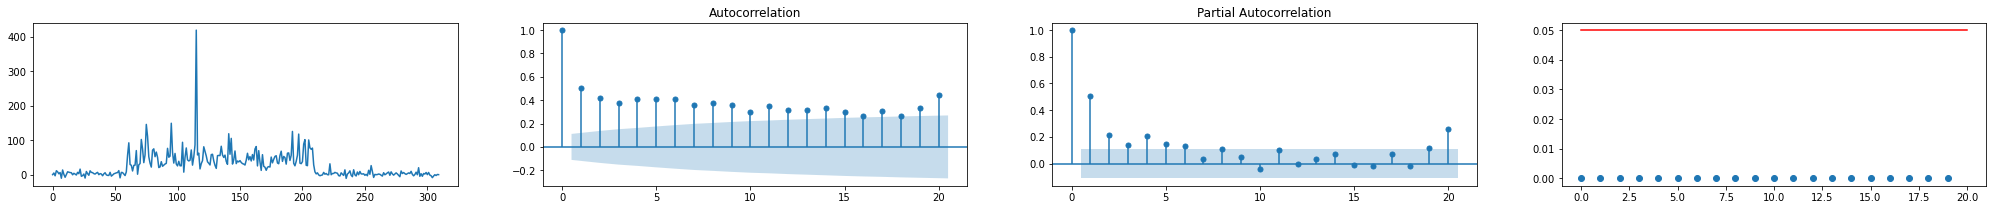

In [62]:
 analyze(df["degree_spondylolisthesis"])

In [63]:
results['biomechanical'] = dict()
results['biomechanical']['att'] = list(df.columns)
results['biomechanical']['att_n'] = [x for x in df.columns  if np.issubdtype(df[x].dtype, np.number)]
results['biomechanical']['att_t'] = []
results['biomechanical']['summary'] = s
results['biomechanical']['g_att'] = g
results['biomechanical']['gd'] = False
results['biomechanical']['att_td'] = [idx for idx,row in dfa.iterrows() if row['Ocurrences [%]']>50]
results['biomechanical']

{'att': ['pelvic_incidence',
  'pelvic_tilt',
  'lumbar_lordosis_angle',
  'sacral_slope',
  'pelvic_radius',
  'degree_spondylolisthesis',
  'class'],
 'att_n': ['pelvic_incidence',
  'pelvic_tilt',
  'lumbar_lordosis_angle',
  'sacral_slope',
  'pelvic_radius',
  'degree_spondylolisthesis'],
 'att_t': [],
 'summary':                           % data  groups  avg_temp_att  std  avg_corr  \
 pelvic_incidence               0       0           NaN  NaN  0.000000   
 pelvic_tilt                    0       0           NaN  NaN  0.000000   
 lumbar_lordosis_angle          0       0           NaN  NaN  0.000000   
 sacral_slope                   0       0           NaN  NaN  0.000000   
 pelvic_radius                  0       0           NaN  NaN  0.000000   
 degree_spondylolisthesis       0       0           NaN  NaN  0.000000   
 class                          0       0           NaN  NaN  0.000000   
 no-grouping                  100       1           2.0  0.0  0.506095   
 
            

### Avocado prices


In [64]:
!kaggle datasets download -d neuromusic/avocado-prices
zf = zipfile.ZipFile('avocado-prices.zip') 
df = pd.read_csv(zf.open('avocado.csv'),sep=',')
df = df.dropna()
df

avocado-prices.zip: Skipping, found more recently modified local copy (use --force to force download)


,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


In [65]:
s,r,g = analyzeDB_attGrouping(df)
s

Most probable grouping attribute is: type


,% data,groups,avg_temp_att,std,avg_corr,max_corr
Unnamed: 0,100,53,1.811321,0.391254,14.814575,16.208333
Date,54,92,1.000000,0.000000,2.916053,7.373611
AveragePrice,97,182,2.835165,2.157347,8.431712,18.960396
Total Volume,0,0,NaN,NaN,0.000000,0.000000
4046,1,2,4.500000,3.500000,5.454174,15.646484
4225,0,1,7.000000,0.000000,2.082349,4.164697
4770,30,2,5.000000,4.000000,6.891118,19.840022
Total Bags,0,1,1.000000,0.000000,0.272849,0.545697
Small Bags,1,6,1.833333,1.863390,1.787197,8.949424
Large Bags,15,13,2.769231,2.606319,4.250413,19.217684


In [66]:
dfa = getTemporalAtt(df, r, s)
dfa

Filter attibute type
Threshold = 50


,Ocurrences [%]
Unnamed: 0,100.0
AveragePrice,100.0
Total Volume,100.0
4046,100.0
4225,100.0
4770,100.0
Total Bags,100.0
Small Bags,100.0
Large Bags,100.0
XLarge Bags,100.0


In [67]:
results['avocado'] = dict()
results['avocado']['att'] = list(df.columns)
results['avocado']['att_n'] = [x for x in df.columns  if np.issubdtype(df[x].dtype, np.number)]
results['avocado']['att_t'] = ['Unnamed: 0','AveragePrice','Total Volume','4046','4225','4770','Total Bags','Small Bags','Large Bags','XLarge Bags','year']
results['avocado']['summary'] = s
results['avocado']['g_att'] = g
results['avocado']['gd'] = True
results['avocado']['att_td'] = [idx for idx,row in dfa.iterrows() if row['Ocurrences [%]']>50]
results['avocado']

{'att': ['Unnamed: 0',
  'Date',
  'AveragePrice',
  'Total Volume',
  '4046',
  '4225',
  '4770',
  'Total Bags',
  'Small Bags',
  'Large Bags',
  'XLarge Bags',
  'type',
  'year',
  'region'],
 'att_n': ['Unnamed: 0',
  'AveragePrice',
  'Total Volume',
  '4046',
  '4225',
  '4770',
  'Total Bags',
  'Small Bags',
  'Large Bags',
  'XLarge Bags',
  'year'],
 'att_t': ['Unnamed: 0',
  'AveragePrice',
  'Total Volume',
  '4046',
  '4225',
  '4770',
  'Total Bags',
  'Small Bags',
  'Large Bags',
  'XLarge Bags',
  'year'],
 'summary':               % data  groups  avg_temp_att       std   avg_corr   max_corr
 Unnamed: 0       100      53      1.811321  0.391254  14.814575  16.208333
 Date              54      92      1.000000  0.000000   2.916053   7.373611
 AveragePrice      97     182      2.835165  2.157347   8.431712  18.960396
 Total Volume       0       0           NaN       NaN   0.000000   0.000000
 4046               1       2      4.500000  3.500000   5.454174  15.646484
 4

### Suicide Rates

In [68]:
!kaggle datasets download -d russellyates88/suicide-rates-overview-1985-to-2016
zf = zipfile.ZipFile('suicide-rates-overview-1985-to-2016.zip') 
df = pd.read_csv(zf.open('master.csv'),sep=',')
df = df.dropna()
df

suicide-rates-overview-1985-to-2016.zip: Skipping, found more recently modified local copy (use --force to force download)


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
72,Albania,1995,male,25-34 years,13,232900,5.58,Albania1995,0.619,"2,424,499,009",835,Generation X
73,Albania,1995,male,55-74 years,9,178000,5.06,Albania1995,0.619,"2,424,499,009",835,Silent
74,Albania,1995,female,75+ years,2,40800,4.90,Albania1995,0.619,"2,424,499,009",835,G.I. Generation
75,Albania,1995,female,15-24 years,13,283500,4.59,Albania1995,0.619,"2,424,499,009",835,Generation X
76,Albania,1995,male,15-24 years,11,241200,4.56,Albania1995,0.619,"2,424,499,009",835,Generation X
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z


In [69]:
s,r,g=analyzeDB_attGrouping(df)
s

Most probable grouping attribute is: sex


,% data,groups,avg_temp_att,std,avg_corr,max_corr
country,100,90,5.000000,0.954521,7.124822,10.526570
year,100,10,5.000000,0.000000,3.979016,5.192621
sex,100,2,6.000000,0.000000,8.451361,12.761156
age,100,6,5.833333,0.372678,5.259892,6.629181
suicides_no,40,27,1.629630,0.986882,0.897031,5.553408
population,0,0,NaN,NaN,0.000000,0.000000
suicides/100k pop,23,94,1.085106,0.376421,0.928267,5.553408
country-year,91,641,1.717629,0.677117,0.822300,0.916667
HDI for year,98,297,3.585859,1.589169,2.281870,9.345238
gdp_for_year ($),91,641,1.717629,0.677117,0.822300,0.916667


In [70]:
dfa = getTemporalAtt(df, r, s)
dfa

Filter attibute sex
Threshold = 50


,Ocurrences [%]
year,100.0
suicides_no,100.0
population,100.0
suicides/100k pop,100.0
HDI for year,100.0
gdp_per_capita ($),100.0


In [71]:
results['suicides'] = dict()
results['suicides']['att'] = list(df.columns)
results['suicides']['att_n'] = [x for x in df.columns  if np.issubdtype(df[x].dtype, np.number)]
results['suicides']['att_t'] = ['year','suicides_no','population','suicides/100k pop','HDI for year','gdp_per_capita ($)']
results['suicides']['summary'] = s
results['suicides']['g_att'] = g
results['suicides']['gd'] = True
results['suicides']['att_td'] = [idx for idx,row in dfa.iterrows() if row['Ocurrences [%]']>50]
results['suicides']

{'att': ['country',
  'year',
  'sex',
  'age',
  'suicides_no',
  'population',
  'suicides/100k pop',
  'country-year',
  'HDI for year',
  ' gdp_for_year ($) ',
  'gdp_per_capita ($)',
  'generation'],
 'att_n': ['year',
  'suicides_no',
  'population',
  'suicides/100k pop',
  'HDI for year',
  'gdp_per_capita ($)'],
 'att_t': ['year',
  'suicides_no',
  'population',
  'suicides/100k pop',
  'HDI for year',
  'gdp_per_capita ($)'],
 'summary':                     % data  groups  avg_temp_att       std   avg_corr  \
 country                100      90      5.000000  0.954521   7.124822   
 year                   100      10      5.000000  0.000000   3.979016   
 sex                    100       2      6.000000  0.000000   8.451361   
 age                    100       6      5.833333  0.372678   5.259892   
 suicides_no             40      27      1.629630  0.986882   0.897031   
 population               0       0           NaN       NaN   0.000000   
 suicides/100k pop       23   

### Crime

In [72]:
!kaggle datasets download -d mascotinme/population-against-crime
zf = zipfile.ZipFile('population-against-crime.zip') 
df = pd.read_csv(zf.open('LocalCrimeOneYearofData2012.csv'),sep=',')
df

population-against-crime.zip: Skipping, found more recently modified local copy (use --force to force download)


,Agency,State,Months,Population,Violent_crime_total,Murder_and_Manslaughter,Forcible_rape,Robbery,Aggravated_assault,Property_crime_total,Burglary,Larceny_theft,Motor_vehicle_theft,lat,long
0,Abilene Police Dept,TX,12,119886,472,3,38,127,304,4393,1037,3185,171,32.4887,99.7331
1,Akron City Police Dept,OH,12,198390,1759,24,167,577,991,10034,3429,5884,721,41.0814,81.5190
2,Alexandria Police Dept,VA,12,145892,243,0,9,138,96,2990,281,2383,326,38.8048,77.0469
3,Allentown City Police Dept,PA,12,119334,653,15,54,374,210,4603,1248,2987,368,40.6084,75.4902
4,Amarillo Police Dept,TX,12,196576,1278,10,110,278,880,8900,2087,6184,629,35.2220,101.8313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,Wilmington Police Dept,NC,12,109370,618,8,23,261,326,5910,1694,3843,373,34.2250,77.9447
209,Winston-Salem Police Dept,NC,12,234687,1556,6,74,428,1048,13701,4529,8490,682,30.0999,80.2442
210,Woodbridge Police Dept,NJ,12,100612,122,0,3,55,64,1967,338,1514,115,38.6582,77.2497
211,Worcester Police Dept,MA,12,183247,1758,8,33,419,1298,6432,2040,3927,465,42.2626,71.8023


In [73]:
s,r,g=analyzeDB_attGrouping(df)
s

Most probable grouping attribute is: no-grouping


,% data,groups,avg_temp_att,std,avg_corr,max_corr
Agency,0,0,NaN,NaN,0.000000,0.000000
State,11,1,1.000000,0.000000,0.272942,0.545884
Months,0,0,NaN,NaN,0.000000,0.000000
Population,0,0,NaN,NaN,0.000000,0.000000
Violent_crime_total,0,0,NaN,NaN,0.000000,0.000000
Murder_and_Manslaughter,23,3,1.333333,0.471405,0.453482,0.660542
Forcible_rape,0,0,NaN,NaN,0.000000,0.000000
Robbery,0,0,NaN,NaN,0.000000,0.000000
Aggravated_assault,0,0,NaN,NaN,0.000000,0.000000
Property_crime_total,0,0,NaN,NaN,0.000000,0.000000


In [74]:
dfa = getTemporalAtt(df, r, s)
dfa

Filter attibute Murder_and_Manslaughter
Threshold = 50


,Ocurrences [%]
lat,33.333333
Burglary,33.333333
Motor_vehicle_theft,33.333333
long,33.333333


In [75]:
results['crime'] = dict()
results['crime']['att'] = list(df.columns)
results['crime']['att_n'] = [x for x in df.columns  if np.issubdtype(df[x].dtype, np.number)]
results['crime']['att_t'] = []
results['crime']['summary'] = s
results['crime']['g_att'] = g
results['crime']['gd'] = False
results['crime']['att_td'] = [idx for idx,row in dfa.iterrows() if row['Ocurrences [%]']>50]
results['crime']

{'att': ['Agency',
  'State',
  'Months',
  'Population',
  'Violent_crime_total',
  'Murder_and_Manslaughter',
  'Forcible_rape',
  'Robbery',
  'Aggravated_assault',
  'Property_crime_total',
  'Burglary',
  'Larceny_theft',
  'Motor_vehicle_theft',
  'lat',
  'long'],
 'att_n': ['Months',
  'Population',
  'Violent_crime_total',
  'Murder_and_Manslaughter',
  'Forcible_rape',
  'Robbery',
  'Aggravated_assault',
  'Property_crime_total',
  'Burglary',
  'Larceny_theft',
  'Motor_vehicle_theft',
  'lat',
  'long'],
 'att_t': [],
 'summary':                          % data  groups  avg_temp_att       std  avg_corr  \
 Agency                        0       0           NaN       NaN  0.000000   
 State                        11       1      1.000000  0.000000  0.272942   
 Months                        0       0           NaN       NaN  0.000000   
 Population                    0       0           NaN       NaN  0.000000   
 Violent_crime_total           0       0           NaN       N

In [14]:
with open('results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Analysis

In [5]:
results = dict()
with open('results.pickle', 'rb') as handle:
    results = pickle.load(handle)
    

In [27]:
results['crime']['case'] = 0
results['countries']['case'] = 0
results['biomechanical']['case'] = 0
results['elections']['case'] = 0
results['incomes']['case'] = 0

results['covid1']['case'] = 1
results['energy1']['case'] = 1
results['yahoo']['case'] = 1
results['exchange']['case'] = 1
results['india']['case'] = 1

results['wage']['case'] = 2
results['market']['case'] = 2
results['covid2']['case'] = 2
results['avocado']['case'] = 2
results['suicides']['case'] = 2

In [15]:
def get_contingency(case, decision):
    if case==True and decision==True:
        return 'TP'
    if case==True and decision==False:
        return 'FN'
    if case==False and decision==True:
        return 'FP'
    if case==False and decision==False:
        return 'TN'

In [28]:
db_details = dict()
db_summary = dict()
db_result  = dict()

for k1 in results.keys():
    atts = results[k1]['att_n']
    att_t  = [True if x in results[k1]['att_t']  else False for x in atts]    
    att_td = [True if x in results[k1]['att_td'] else False for x in atts]

    contingency = [get_contingency(x in results[k1]['att_t'], x in results[k1]['att_td']) for x in atts]
    
    data = {'Detected as temporal':f"{att_td}/{att_t}", 'Contingency':contingency}
    db_details[k1] = pd.DataFrame(data, index=atts) 
    print(k1)
    db_summary[k1] = dict()
    db_summary[k1]['case'] = results[k1]['case']
    db_summary[k1]['FP'] = contingency.count('FP')
    db_summary[k1]['TP'] = contingency.count('TP')
    db_summary[k1]['FN'] = contingency.count('FN') 
    db_summary[k1]['TN'] = contingency.count('TN')
    db_summary[k1]['ACC'] = (db_summary[k1]['TP']+db_summary[k1]['TN']) / ( db_summary[k1]['TP'] + db_summary[k1]['FP'] + db_summary[k1]['FN'] + db_summary[k1]['TN'])  

    try:
        db_summary[k1]['F1'] = db_summary[k1]['TP'] / ( db_summary[k1]['TP'] + 1/2 *(db_summary[k1]['FP']+db_summary[k1]['FN']) ) 
    except:
        db_summary[k1]['F1'] = 'N/A'
    db_summary[k1]['# temp att detected'] = f"{sum(att_td) }/{sum(att_t) }"
    db_summary[k1]['grouping'] = False if results[k1]['g_att'] == 'no-grouping' else True 
    db_summary[k1]['grouping detected'] = results[k1]['gd'] 
    db_summary[k1]['Contingency'] = get_contingency(db_summary[k1]['grouping'], db_summary[k1]['grouping detected'])
    db_summary_df = pd.DataFrame.from_dict(db_summary).T
    db_summary_df = db_summary_df.sort_values(by='case')

display(HTML(db_summary_df.to_html()))


db_result['grouping'] = dict()

db_result['grouping']['FP'] = list(db_summary_df['Contingency'].values).count('FP')
db_result['grouping']['TP'] = list(db_summary_df['Contingency'].values).count('TP')
db_result['grouping']['FN'] = list(db_summary_df['Contingency'].values).count('FN') 
db_result['grouping']['TN'] = list(db_summary_df['Contingency'].values).count('TN')
db_result['grouping']['F1'] = db_result['grouping']['TP'] / ( db_result['grouping']['TP'] + 1/2 *(db_result['grouping']['FP']+db_result['grouping']['FN']) ) 

db_result_df = pd.DataFrame.from_dict(db_result).T
display(HTML(db_result_df.to_html()))


covid1
covid2
energy1
wage
yahoo
market
elections
incomes
countries
india
biomechanical
avocado
suicides
crime
exchange


,case,FP,TP,FN,TN,ACC,F1,# temp att detected,grouping,grouping detected,Contingency
elections,0,0,0,0,3,1,N/A,0/0,False,False,TN
incomes,0,0,0,0,3,1,N/A,0/0,False,False,TN
countries,0,2,0,0,16,0.888889,0,2/0,False,False,TN
biomechanical,0,2,0,0,4,0.666667,0,2/0,False,False,TN
crime,0,0,0,0,13,1,N/A,0/0,False,False,TN
covid1,1,0,2,0,0,1,1,2/2,False,False,TN
energy1,1,0,4,0,0,1,1,4/4,False,False,TN
yahoo,1,0,101,0,0,1,1,101/101,False,False,TN
india,1,0,2,0,0,1,1,2/2,False,False,TN
exchange,1,0,8,0,0,1,1,8/8,False,False,TN


,F1,FN,FP,TN,TP
grouping,1.0,0.0,0.0,10.0,5.0


In [ ]:
for k,df in db_details.items():
    display(HTML(df.to_html()))
    print('')

### example database for paper

In [82]:
!wget https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv

--2021-04-01 23:00:15--  https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48199156 (46M) [text/plain]
Saving to: ‘us-counties.csv.8’

us-counties.csv.8   100%[===================>]  45.97M  1.88MB/s    in 21s     

2021-04-01 23:00:37 (2.18 MB/s) - ‘us-counties.csv.8’ saved [48199156/48199156]



In [83]:
df = pd.read_csv('us-counties.csv')
df = df[['date','county', 'cases', 'deaths']]
df

,date,county,cases,deaths
0,2020-01-21,Snohomish,1,0.0
1,2020-01-22,Snohomish,1,0.0
2,2020-01-23,Snohomish,1,0.0
3,2020-01-24,Cook,1,0.0
4,2020-01-24,Snohomish,1,0.0
...,...,...,...,...
991912,2021-02-02,Sweetwater,3510,33.0
991913,2021-02-02,Teton,3151,7.0
991914,2021-02-02,Uinta,1975,12.0
991915,2021-02-02,Washakie,867,26.0


In [84]:
df.loc[df['county'] == 'Larimer'].tail(5)

,date,county,cases,deaths
975965,2021-01-29,Larimer,17914,192.0
979210,2021-01-30,Larimer,17914,192.0
982456,2021-01-31,Larimer,17914,192.0
985703,2021-02-01,Larimer,18115,196.0
988950,2021-02-02,Larimer,18160,198.0


In [85]:
df.loc[df['county'] == 'Boulder'].tail(5)

,date,county,cases,deaths
975936,2021-01-29,Boulder,17225,232.0
979181,2021-01-30,Boulder,17279,232.0
982427,2021-01-31,Boulder,17329,232.0
985674,2021-02-01,Boulder,17376,232.0
988921,2021-02-02,Boulder,17433,232.0


In [86]:
s,r,g = analyzeDB_attGrouping(df)
s

Most probable grouping attribute is: county


,% data,groups,avg_temp_att,std,avg_corr,max_corr
date,0,0,NaN,NaN,0.000000,0.000000
county,95,1923,1.939158,0.239041,15.814377,18.813475
cases,0,196,1.000000,0.000000,0.616551,1.703790
deaths,1,314,1.000000,0.000000,0.833849,3.475165
no-grouping,100,1,0.000000,0.000000,0.000000,0.000000


In [87]:
dfa = getTemporalAtt(df, r, s)
dfa

Filter attibute county
Threshold = 50


,Ocurrences [%]
cases,100.000000
deaths,93.915757
